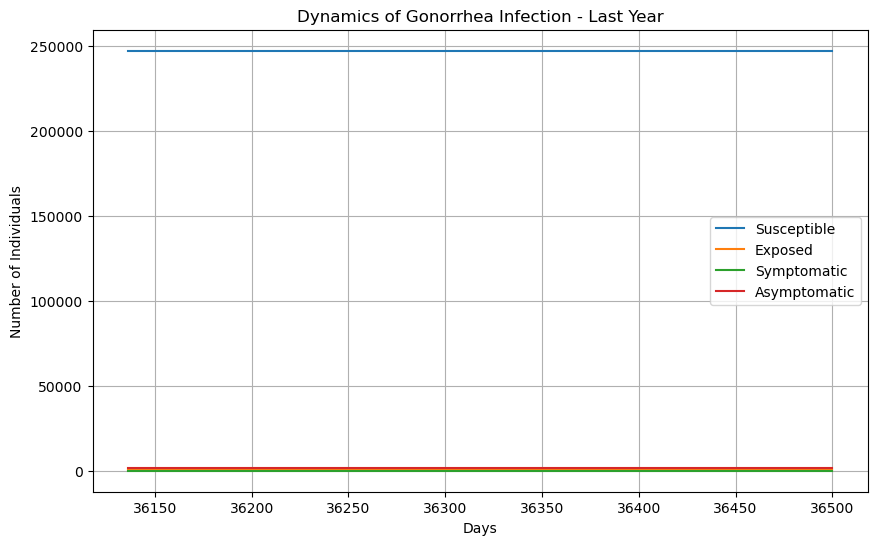

Yearly cases at steady state: 40411.901150765625
Yearly known cases at steady state: 10261.021530638402


In [1]:
#Delay DE

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.8*(2/30)        # Transmission rate, 80% infection prob * (2 partners per month)
epsilon = 1/5            # Rate of progression from exposed to infectious (inverse of latent period)
gamma_t = 1/7            # Rate of recovery for treated individuals (they immediately get treated)
gamma_u = 0.60 *(1/14)      # Natural recovery rate for untreated individuals
lambda_ = 0.75         # Proportion developing asymptomatic infection
N = 250000               # Total population
p_3months = 0.3          # Proportion tested every 3 months
p_12months = 0.7         # Proportion tested every 12 months

# Initial conditions
E0 = 0.5 * N             # Initial exposed individuals.
X0 = N - E0              # Initial susceptible individuals.
S0 = 0                   # Initial symptomatic individuals.
A0 = 0                   # Initial asymptomatic individuals.

# Define the delayed model
def gonorrhea_model_delay(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, p_3months, p_12months, tau, N):
    # Since we cannot directly use the delayed A value in the ODEs, we need to find a workaround
    # Using the history of A to find the delayed value
    A_delayed = np.interp(t - tau, t_points, A_history)
    
    X, E, S, A = Y
    
    testing_rate = (p_3months/91 + p_12months/365)
    
    dXdt = -beta * X * (S + A) / N + gamma_t * S + gamma_u * A+gamma_t*testing_rate* A_delayed
    dEdt = beta * X * (S + A) / N - epsilon * E
    dSdt = (1 - lambda_) * epsilon * E - gamma_t * S
    dAdt = lambda_ * epsilon * E - gamma_t*testing_rate * A_delayed - gamma_u * A
    
    return [dXdt, dEdt, dSdt, dAdt]

# Time array: Simulate over 10 years
t_points = np.linspace(0, 100 * 365, 100 * 365)
tau = 50  # Delay in days for getting test results

# We need to keep a history of the A compartment to look up delayed values
A_history = np.zeros(t_points.shape)
A_history[0] = A0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

# Loop over each day and solve the ODEs
solution = np.zeros((len(t_points), 4))
solution[0] = [X0, E0, S0, A0]

for i in range(1, len(t_points)):
    tspan = [t_points[i-1], t_points[i]]
    ys = odeint(gonorrhea_model_delay, solution[i-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, p_3months, p_12months, tau, N), atol=abserr, rtol=relerr)
    
    # Update the solution
    solution[i] = ys[-1]
    
    # Update A's history
    A_history[i] = ys[-1][3]

# Extract the last year's data for steady state
last_year_solution = solution[-365:]

# Calculate the yearly new cases for symptomatic and asymptomatic
yearly_symptomatic_cases = (1 - lambda_) * epsilon * np.sum(last_year_solution[:, 1])
yearly_asymptomatic_cases = lambda_ * epsilon * np.sum(last_year_solution[:, 1])

# Total yearly cases are the sum of new symptomatic and asymptomatic cases
yearly_cases = yearly_symptomatic_cases + yearly_asymptomatic_cases

# Total known cases are those symptomatic and a proportion of the asymptomatic that are tested and detected
testing_proportion = (p_3months/91 + p_12months/365)  # This assumes continuous uniform testing throughout the year
yearly_known_cases = yearly_symptomatic_cases + testing_proportion * yearly_asymptomatic_cases

# Create time points for the last year
last_year_days = t_points[-365:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(last_year_days, last_year_solution[:, 0], label='Susceptible')
plt.plot(last_year_days, last_year_solution[:, 1], label='Exposed')
plt.plot(last_year_days, last_year_solution[:, 2], label='Symptomatic')
plt.plot(last_year_days, last_year_solution[:, 3], label='Asymptomatic')
plt.xlabel('Days')
plt.ylabel('Number of Individuals')
plt.title('Dynamics of Gonorrhea Infection - Last Year')
plt.legend()
plt.grid(True)
plt.show()

print(f"Yearly cases at steady state: {yearly_cases}")
print(f"Yearly known cases at steady state: {yearly_known_cases}")


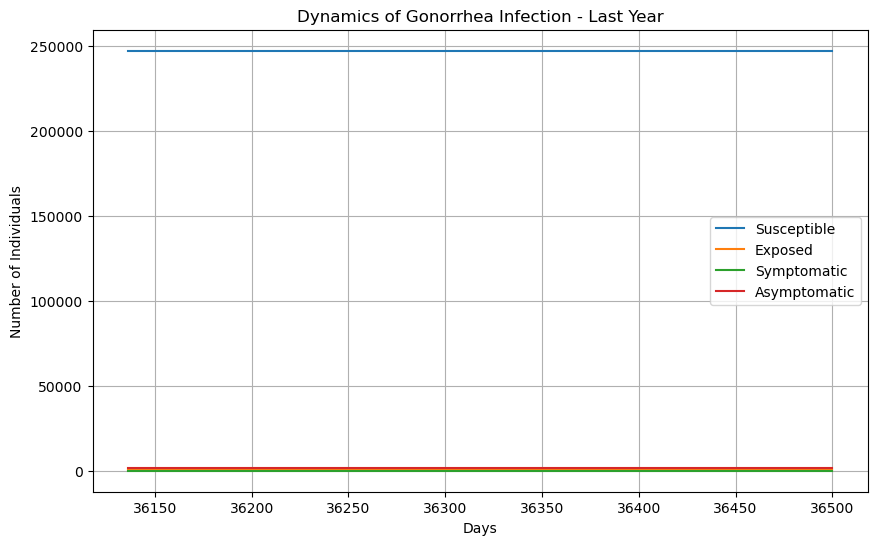

Yearly cases at steady state: 42847.55869971723
Yearly known cases at steady state: 10879.461491129616
